# HSV Operator Example

This example presents HSV manipulation operation within DALI and how to easily set up a pipeline with it.
## HSV Color Space
HSV Color space is an alternative to RGB (and many more color spaces) for representation of images. It somewhat more intuitive than RGB, since the model better fits human perception of colors. For more information on this, just use [Wikipedia](https://en.wikipedia.org/wiki/HSL_and_HSV).
## Step-by-step guide
1. Let's start from importing handful of utils and DALI itself.


In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops            
import nvidia.dali.types as types
import matplotlib.pyplot as plt

batch_size = 1
image_filename = "images"

used `batch_size` is `1`, to keep things simple. You can always extend it on your own.

2. Next, let's implement the pipelines. We've presented 2 versions of a pipeline. The CPU one does all the processing (i.e. reading file, decoding it and HSV manipulation) on the CPU, while the other pipeline conducts decoding and HSV manipulation on the GPU.

In [2]:
class HsvCpuPipeline(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super(HsvCpuPipeline, self).__init__(batch_size, num_threads, device_id, seed=42)
        self.input = ops.FileReader(device="cpu", file_root=image_filename)
        self.decode = ops.ImageDecoder(device="cpu", output_type=types.RGB)
        self.hsv = ops.Hsv(device="cpu", hue=120, saturation=1, value=.4, output_type=types.RGB)

    def define_graph(self):                                                                
        read, _ = self.input()
        image = self.decode(read)
        converted = self.hsv(image)
        return image, converted
    
class HsvGpuPipeline(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super(HsvGpuPipeline, self).__init__(batch_size, num_threads, device_id, seed=42)
        self.input = ops.FileReader(device="cpu", file_root=image_filename)
        self.decode = ops.ImageDecoder(device="mixed", output_type=types.RGB)
        self.hsv = ops.Hsv(device="gpu", hue=-120, saturation=2, value=1, output_type=types.RGB)

    def define_graph(self):                                                                
        read, _ = self.input()
        image = self.decode(read)
        converted = self.hsv(image.gpu())
        return image, converted

The function below is used to actually display result of HSV manipulation in DALI. Since the pipelines we set up return 2 outputs: modified image and original image, the function aquires both of them from the output and displays them. Additional flag (`cpu`) is specified, to determine, whether the pipeline output comes from CPU or GPU. In the latter case, we have to tell the output, to return a CPU-accessible copy of the data.

In [3]:
def display(output, cpu = True):
    img1 = output[0].at(0) if cpu else output[0].as_cpu().at(0)
    img2 = output[1].at(0) if cpu else output[1].as_cpu().at(0)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(img1);
    ax[1].imshow(img2);

3. Now let's just build the pipelines, run them and display the results. First the GPU one:

In [4]:
pipegpu = HsvGpuPipeline(batch_size=batch_size, num_threads=1, device_id=0)
pipegpu.build()          
gpu_output = pipegpu.run()

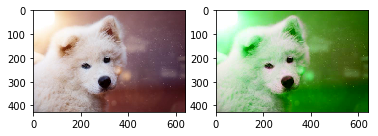

In [5]:
display(gpu_output, cpu=False)

4. And the CPU:

In [6]:
pipecpu = HsvCpuPipeline(batch_size=batch_size, num_threads=1, device_id=0)
pipecpu.build()          
cpu_output = pipecpu.run()

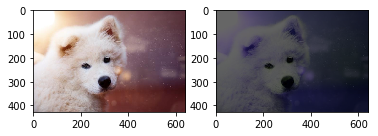

In [7]:
display(cpu_output)